In [1]:
import socket
import time
import numpy as np
import hmac
import time

In [2]:

def divide_text(text, block_size_bits = 16, X= None):
    text = text.encode('utf-8') 
    blocks = np.array([])
    for i in range(0, len(text), block_size_bits//8):
       blocks = np.append(blocks,text[i:i+block_size_bits//8])
    #append b'' to block make the len of blocks to be a multiple of xsahpe
    if X.shape[0] is not None and len(blocks)%X.shape[0]!=0:
        for i in range(X.shape[0] - len(blocks)%X.shape[0]):
            blocks = np.append(blocks,b'')
    return blocks

def mac_for_block(blocks:np.array, key:str, X:np.array, Y:np.array):
    res = {}
    for msg in range(X.shape[0]):
        res[msg] = blocks[msg].tobytes()
    for tags in range(X.shape[1]):
        data = b''.join(blocks[np.where(X[:,tags] == 1)]) 
        res[np.where(Y[:,tags] == 1)[0][0]] =  blocks[np.where(Y[:,tags] == 1)][0] + hmac.new(key, data, digestmod='sha384').digest()
    return res

def send_msg(FN, msg, sock, dest):
    sock.sendto(FN.to_bytes(4, 'big')+ msg, dest)
    # print(FN.to_bytes(4, 'big')+ msg)


def tx(text, sock, ip, port, X, Y, block_size_bits = 128, attack = []):
    blocks= divide_text(text, block_size_bits=block_size_bits, X = X)
    FN = 1
    TOTAL_MAC_LENGTH = 0
    for i in range(len(blocks)//X.shape[0]):
        block = mac_for_block(blocks[i*X.shape[0]:i*X.shape[0]+X.shape[0]], key = b"key", X = X, Y = Y)
        TOTAL_MAC_LENGTH += X.shape[1]*384//8
        for msg in block.values():
            if FN in attack:
                # print("Dropped")
                FN += 1
                continue
            else:
                send_msg(FN, msg, sock, (ip,port) )
                FN += 1 
                time.sleep(0.01)

    sock.sendto(b'END', (ip,port))
    sock.close()
    time.sleep(1)
    return TOTAL_MAC_LENGTH

# mac_for_block(divide_text(text), b"key")


In [3]:
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
X = np.array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 1,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  1], # m3
              [ 0,  1,  0,  0,  0,  0,  1,  0,  0], # m4
              [ 0,  1,  0,  0,  0,  0,  0,  1,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  1], # m6
              [ 0,  0,  1,  0,  0,  0,  1,  0,  0], # m7
              [ 0,  0,  1,  0,  0,  0,  0,  1,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  1], # m9
              [ 0,  0,  0,  1,  0,  0,  1,  0,  0], # m10
              [ 0,  0,  0,  1,  0,  0,  0,  1,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  1], # m12
              [ 0,  0,  0,  0,  1,  0,  1,  0,  0], # m13
              [ 0,  0,  0,  0,  1,  0,  0,  1,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  1], # m15
              [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  1,  0], # m17
              [ 0,  0,  0,  0,  0,  1,  0,  0,  1]]) # m18
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
Y = np.array([[ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # m3
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m4
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # m6
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m7
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m9
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m10
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m12
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m13
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m15
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m17
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18

# randomly selecting a message of 18 messages to drop

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
ip = "0.0.0.0"
port = 23422

message_size_in_bits = 1024


with open("send.txt", "r") as f:
    text = f.read()
print("len Text: ", len(text))
attack = np.random.randint(1,len(divide_text(text,message_size_in_bits, X)),50)
print(len(text)/2)

print(f'Attacking on paccket numbers {attack}\nTransmitting text: {text}\n\n')



print('transmitting in 2D mode ...')
tx(text, sock, ip, port, X, Y,block_size_bits = message_size_in_bits, attack = attack)

len Text:  150192
75096.0
Attacking on paccket numbers [ 370  164  985 1103  671  634  610  857 1058 1113  158  243   15 1046
 1072  297  556  786   90  838  694  960  147  504  535  806  111 1168
 1158 1021  360  664  906 1097 1070  791  653  999  722  206  651 1004
  468  611 1172  255  690  885   81  747]
Transmitting text: This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.
This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D integrity check is better than  blockwise integrity.This test shows  2D in

28512

In [7]:
1056128/(150192*8+28512*8)

0.7387411585638822

In [4]:
# identity matrix
X = np.eye(18) # tag generation matrix
Y = np.eye(18) # tag assignment matrix

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
ip = "0.0.0.0"
port = 23422


print('transmitting in blockwise tag mode ...')
tx(text, sock, ip, port, X, Y,block_size_bits = message_size_in_bits, attack = attack)



transmitting in blockwise tag mode ...


57024

In [8]:
1076608/(150192*8+57024*8)

0.6494479190796077

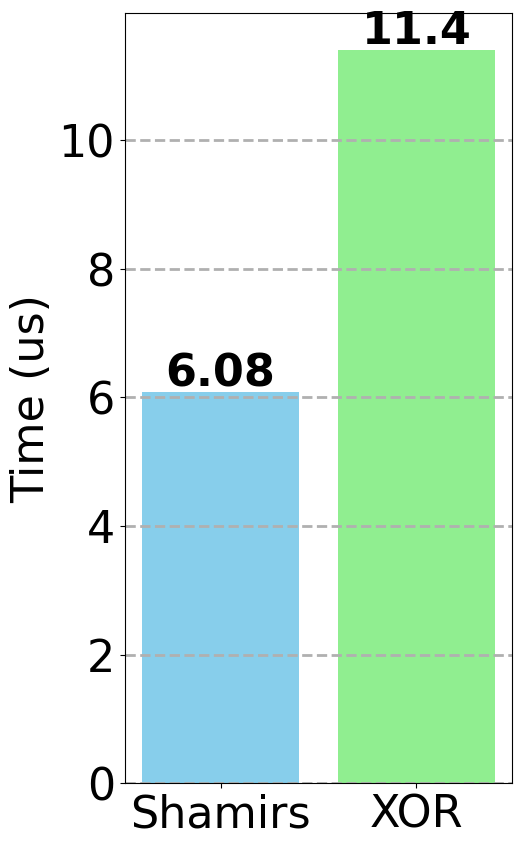

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the charts
labels_left = ['Shamirs', 'XOR']
times_left = [6.08,11.4]

labels_right = ['Shamir', 'E1,E2', 'E1,E3', 'E2,E3']
times_right = [69.16, 3.0, 3.68, 3.43]

# make the fonr 32
plt.rc('font', size=32)          # controls default text sizes
# Create the figure and the two subplots
# change the fig style
plt.figure(figsize=(5, 10), dpi=100)
# Plot for the left chart
bars_left = plt.bar(labels_left, times_left, color=['skyblue', 'lightgreen'])

# seet the  grid
plt.grid(axis='y', linestyle='--', linewidth=2)

# add the y label
plt.ylabel('Time (us)')

# Add labels on top of bars
for bar in bars_left:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval}', ha='center', fontsize=32, fontweight='bold')
plt.show()






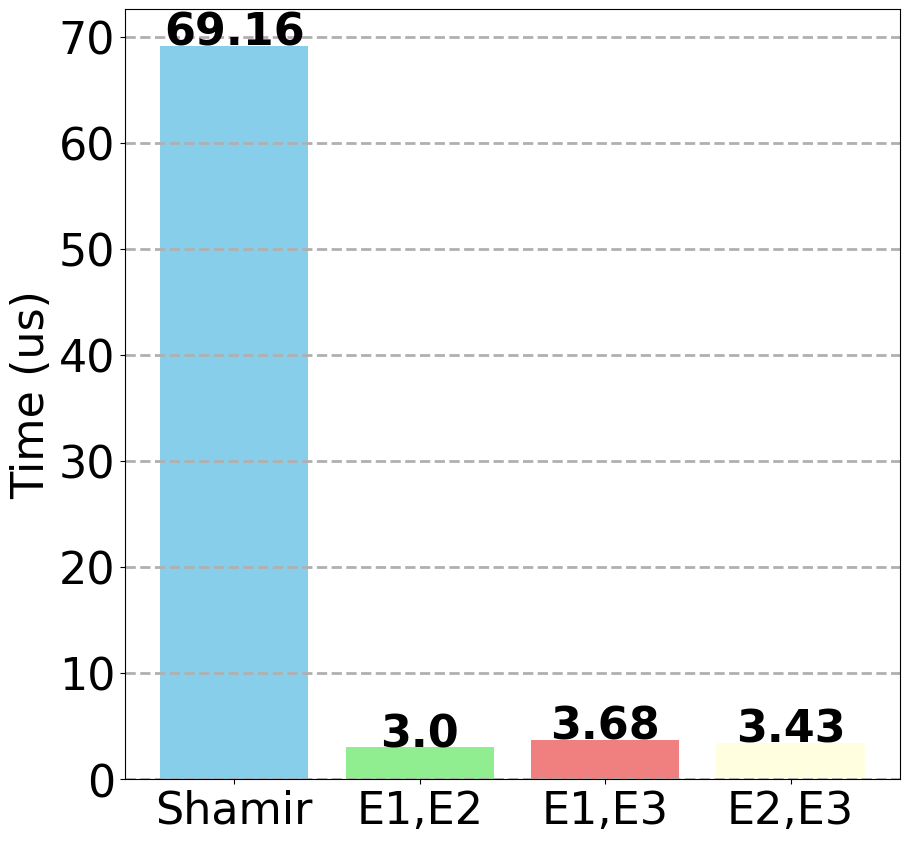

In [39]:

# make the fonr 32
plt.rc('font', size=32)          # controls default text sizes
# Create the figure and the two subplots
# change the fig style
plt.figure(figsize=(10, 10), dpi=100)
# Plot for the left chart
# bars_left = plt.bar(labels_left, times_left, color=['skyblue', 'lightgreen'])
bars_right = plt.bar(labels_right, times_right, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
# seet the  grid
plt.grid(axis='y', linestyle='--', linewidth=2)

# add the y label
plt.ylabel('Time (us)')

# Add labels on top of bars
for bar in bars_right:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval}', ha='center', fontsize=32, fontweight='bold')
plt.show()


